# Jonathan Halverson
# Thursday, December 28, 2017
# Denoising autoencoders

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


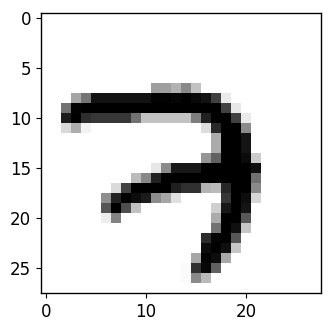

In [3]:
plt.imshow(mnist.train.images[0].reshape(28, 28), cmap='binary')

## Method 1: Add Gaussian noise

### Create the graph

In [4]:
tf.reset_default_graph()

In [5]:
n_inputs = 28 * 28
n_units = n_inputs
n_outputs = n_inputs
strength = 1.0
l2_reg = 0.0001

In [6]:
from functools import partial

X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs))
X_noise = X + strength * tf.random_normal(shape=tf.shape(X), dtype=tf.float32, name='inputs')
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)
hidden1 = my_dense_layer(X_noise, n_units, name='hidden1')
hidden2 = my_dense_layer(hidden1, n_units, name='hidden2')
hidden3 = my_dense_layer(hidden2, n_units, name='hidden3')
outputs = my_dense_layer(hidden3, n_outputs, activation=None, name='outputs')

In [7]:
reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
total_loss = tf.add_n([reconstruction_loss] + reg_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(total_loss)

In [8]:
saver = tf.train.Saver()

In [9]:
init = tf.global_variables_initializer()

### Run the graph

In [10]:
batch_size = 200
epochs = 20
codings = hidden2

In [11]:
ckpt_path = '/tmp/data/final_denoise.ckpt'
with tf.Session() as sess:
     init.run()
     print '-', total_loss.eval(feed_dict={X:mnist.validation.images})
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, _ = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch})
          if not (epoch % 2): print epoch, total_loss.eval(feed_dict={X:mnist.validation.images}), reconstruction_loss.eval(feed_dict={X:mnist.validation.images})
     save_path = saver.save(sess, ckpt_path)

- 2.67334
0 0.184041
2 0.0770661
4 0.0575557
6 0.0511561
8 0.0477866
10 0.0472062
12 0.0458146
14 0.0450651
16 0.0452178
18 0.0447644
20 0.0445191


In [12]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

INFO:tensorflow:Restoring parameters from /tmp/data/final_denoise.ckpt


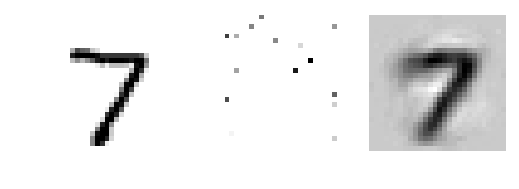

In [13]:
with tf.Session() as sess:
     saver.restore(sess, ckpt_path)
     codings_train = codings.eval(feed_dict={X:X_train})
     codings_test = codings.eval(feed_dict={X:X_test})
     outputs_test = outputs.eval(feed_dict={X:X_test})
     
     plt.subplot(131)
     plt.imshow(X_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')
     plt.subplot(132)
     plt.imshow(codings_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')
     plt.subplot(133)
     plt.imshow(outputs_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
#LogisticRegression(C=1.0).fit(codings_train, y_train).score(codings_test, y_test)

In [16]:
codings_train.shape

(55000, 784)

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, tol=1e-4, loss='log')
sgd_clf.fit(codings_train, y_train).score(codings_test, y_test)

0.68710000000000004

## Method 2: Dropout

In [18]:
tf.reset_default_graph()

In [19]:
n_inputs = 28 * 28
n_units = n_inputs
n_outputs = n_inputs
keep_prob = 0.5

In [20]:
from functools import partial

X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs))
X_dropout = tf.nn.dropout(X, keep_prob)

he_init = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=he_init)
hidden1 = my_dense_layer(X_dropout, n_units, name='hidden1')
hidden2 = my_dense_layer(hidden1, n_units, name='hidden2')
hidden3 = my_dense_layer(hidden2, n_units, name='hidden3')
outputs = my_dense_layer(hidden3, n_outputs, activation=None, name='outputs')

In [21]:
reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(reconstruction_loss)

In [22]:
saver = tf.train.Saver()

In [23]:
init = tf.global_variables_initializer()

In [24]:
batch_size = 200
epochs = 20
codings = hidden2

In [25]:
ckpt_path = '/tmp/data/final_dropout.ckpt'
with tf.Session() as sess:
     init.run()
     print '-', reconstruction_loss.eval(feed_dict={X:mnist.validation.images})
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, _ = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch})
          if not (epoch % 2): print epoch, reconstruction_loss.eval(feed_dict={X:mnist.validation.images})
     save_path = saver.save(sess, ckpt_path)

- 1.2423
0 0.0327296
2 0.0230121
4 0.0204834
6 0.0188967
8 0.017843
10 0.0168321
12 0.016289
14 0.0158027
16 0.015359
18 0.0152067
20 0.0147504


INFO:tensorflow:Restoring parameters from /tmp/data/final_dropout.ckpt


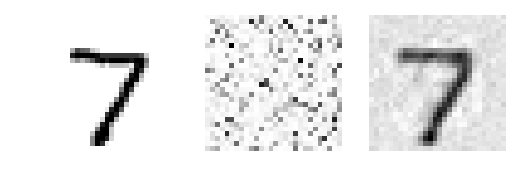

In [26]:
with tf.Session() as sess:
     saver.restore(sess, ckpt_path)
     codings_train = codings.eval(feed_dict={X:X_train})
     codings_test = codings.eval(feed_dict={X:X_test})
     outputs_test = outputs.eval(feed_dict={X:X_test})
     
     plt.subplot(131)
     plt.imshow(X_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')
     plt.subplot(132)
     plt.imshow(codings_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')
     plt.subplot(133)
     plt.imshow(outputs_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')

In [27]:
sgd_clf = SGDClassifier(random_state=42, tol=1e-4, loss='log')
sgd_clf.fit(codings_train, y_train).score(codings_test, y_test)

0.94610000000000005

In [28]:
LogisticRegression(C=0.1).fit(codings_train, y_train).score(codings_test, y_test)

0.94389999999999996

In [29]:
LogisticRegression(C=1.0).fit(codings_train, y_train).score(codings_test, y_test)

0.94910000000000005

In [30]:
LogisticRegression(C=10.0).fit(codings_train, y_train).score(codings_test, y_test)

0.95079999999999998

We see that the features generated with the autoencoder using dropout gave the best performance in terms of accuracy.